In [1]:
## standart libraries
import os,sys
import numpy as np
# xarray
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('tableau-colorblind10')

CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}


In [2]:
# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client

c = Client()
# c = Client(n_workers=6, threads_per_worker=1, memory_limit="8 GiB",local_directory="/gpfsscratch/rech/cli/uor98hu/dask_tmp/")
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35907 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37743 Dashboard: http://127.0.0.1:35907/status,Cluster Workers: 5 Cores: 10 Memory: 20.97 GB


# SAving data

In [3]:
chunk_size = {"x":349,"y":500} 
# arctic no greenland est
Arctic_est_maskN = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/remoteGr_mask/Arctic_est_mask.nc', chunks={"x":349,"y":500}).polymask.squeeze()
Arctic_west_mask = xr.open_dataset('/gpfswork/rech/cli/uor98hu/MYDATA/remoteGr_mask/Arctic_west_mask.nc',chunks={"x":349,"y":500}).polymask.squeeze()
Arctic_NoGrEst_mask = Arctic_est_maskN + Arctic_west_mask

dirisc= "/gpfsscratch/rech/cli/uor98hu/Calcul_psi/"
GAI_psi = xr.open_mfdataset(dirisc+"GAI/"+"*.nc" ,chunks=chunk_size, parallel = True).sobarstf.where(Arctic_NoGrEst_mask,drop=True)
AI_psi  = xr.open_mfdataset(dirisc+"AI/" +"*.nc" ,chunks=chunk_size, parallel = True).sobarstf.where(Arctic_NoGrEst_mask,drop=True)
S_psi   = xr.open_mfdataset(dirisc+"S/"  +"*.nc" ,chunks=chunk_size, parallel = True).sobarstf.where(Arctic_NoGrEst_mask,drop=True)

diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr=xr.open_dataset(diri+'mesh_hgr.nc', chunks={"x":349,"y":500}).squeeze()
# tmask = mesh_hgr.tmask

e1t = mesh_hgr.e1t.where(Arctic_NoGrEst_mask,drop=True)
e2t = mesh_hgr.e2t.where(Arctic_NoGrEst_mask,drop=True)

cell_area = e2t*e1t
area_total = cell_area.sum(("y","x")).compute()
WeightboxBG = (cell_area/area_total) #.compute()

diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split

# figure timeseries

In [4]:
%%time
GAI_psi_wtmean = ((GAI_psi*WeightboxBG).sum(("y","x"))).compute()
AI_psi_wtmean  = ((AI_psi *WeightboxBG).sum(("y","x"))).compute()
S_psi_wtmean   = ((S_psi  *WeightboxBG).sum(("y","x"))).compute()

GAI_S_psi_wtmean  = GAI_psi_wtmean - S_psi_wtmean
GAI_AI_psi_wtmean = GAI_psi_wtmean - AI_psi_wtmean
AI_S_psi_wtmean   = AI_psi_wtmean  - S_psi_wtmean

CPU times: user 54.2 s, sys: 1.94 s, total: 56.2 s
Wall time: 1min 29s


In [6]:
# #trend sur 2005-2018 sur les timeseries en originales
# GAI_S_psi_wtmeanshort  = GAI_S_psi_wtmean.sel(time_counter=slice('2005','2018'))
# GAI_AI_psi_wtmeanshort = GAI_AI_psi_wtmean.sel(time_counter=slice('2005','2018'))
# AI_S_psi_wtmeanshort   = AI_S_psi_wtmean.sel(time_counter=slice('2005','2018'))


In [7]:

# # tranform into yearly data and to the linear regression
# GAI_S_psi_wtmeanshort1y = GAI_S_psi_wtmeanshort.groupby('time_counter.year').mean('time_counter')
# lin_reg = (GAI_S_psi_wtmeanshort1y/1e6).polyfit('year', deg=1)
# polyfit_coeff = lin_reg.polyfit_coefficients.values
# trcurveGAI_S = polyfit_coeff[0]*GAI_S_psi_wtmeanshort1y.year.values + polyfit_coeff[1]

# GAI_AI_psi_wtmeanshort1y = GAI_AI_psi_wtmeanshort.groupby('time_counter.year').mean('time_counter')
# lin_reg = (GAI_AI_psi_wtmeanshort1y/1e6).polyfit('year', deg=1)
# polyfit_coeffgr = lin_reg.polyfit_coefficients.values
# trcurveGAI_AI = polyfit_coeffgr[0]*GAI_AI_psi_wtmeanshort1y.year.values + polyfit_coeffgr[1]

# AI_S_psi_wtmeanshort1y = AI_S_psi_wtmeanshort.groupby('time_counter.year').mean('time_counter')
# lin_reg = (AI_S_psi_wtmeanshort1y/1e6).polyfit('year', deg=1)
# polyfit_coeffriv = lin_reg.polyfit_coefficients.values
# trcurveAI_S = polyfit_coeffriv[0]*AI_S_psi_wtmeanshort1y.year.values + polyfit_coeffriv[1]

# #prepare the time array for the plot
# time = [GAI_S_psi_wtmeanshort.time_counter[6 + i].values for i in np.arange(0,168,12)]
# time4plot = [time[0],time[-1]]
# trGAI_S4plot = [trcurveGAI_S[0],trcurveGAI_S[-1]] 
# trGAI_AI4plot = [trcurveGAI_AI[0],trcurveGAI_AI[-1]]
# trAI_S4plot = [trcurveAI_S[0],trcurveAI_S[-1]] 

# #see the values of the trend
# print(polyfit_coeff[0])
# print(polyfit_coeffgr[0])
# print(polyfit_coeffriv[0])

0.013818197841608239
0.01705800824371773
-0.003239810402109493


In [5]:
#rolling mean
GAI_psi_wtmeanrollmean = GAI_psi_wtmean.rolling(time_counter=12).mean()
AI_psi_wtmeanrollmean = AI_psi_wtmean.rolling(time_counter=12).mean()
S_psi_wtmeanrollmean = S_psi_wtmean.rolling(time_counter=12).mean()

GAI_S_psi_wtmeanrollmean = GAI_S_psi_wtmean.rolling(time_counter=12).mean()
GAI_AI_psi_wtmeanrollmean = GAI_AI_psi_wtmean.rolling(time_counter=12).mean()
AI_S_psi_wtmeanrollmean = AI_S_psi_wtmean.rolling(time_counter=12).mean()

In [12]:
ds_ts = xr.Dataset(
    data_vars=dict(GAI_psi_wtmeanrollmean=(["time_counter"], GAI_psi_wtmeanrollmean.data),
                    AI_psi_wtmeanrollmean=(["time_counter"], AI_psi_wtmeanrollmean.data),
                     S_psi_wtmeanrollmean=(["time_counter"], S_psi_wtmeanrollmean.data)),
    coords=dict(time_counter=(["time_counter"], S_psi_wtmeanrollmean.time_counter.data)),
    attrs=dict(
        description="mean over the mask  No_Gr_est (full arctic as ususally defined) 1980-2018 from monthly psi, puis rolling mean",
        units="m3/s"))

ds_ts.to_netcdf('/gpfswork/rech/cli/uor98hu/MYDATA/psi/eORCA025.L75-IMHOTEP._y1980_2018.1y_GAI_AI_S_psi_ts_AO.nc', mode='w')

In [13]:
ds_ts = xr.Dataset(
    data_vars=dict(GAI_S_psi_wtmeanrollmean=(["time_counter"], GAI_S_psi_wtmeanrollmean.data),
                    GAI_AI_psi_wtmeanrollmean=(["time_counter"], GAI_AI_psi_wtmeanrollmean.data),
                     AI_S_psi_wtmeanrollmean=(["time_counter"], AI_S_psi_wtmeanrollmean.data)),
    coords=dict(time_counter=(["time_counter"], S_psi_wtmeanrollmean.time_counter.data)),
    attrs=dict(
        description="mean over the mask  No_Gr_est (full arctic as ususally defined) 1980-2018 from monthly psi, puis rolling mean for GAI-AI, AI-S, et GAI-S",
        units="m3/s"))

ds_ts.to_netcdf('/gpfswork/rech/cli/uor98hu/MYDATA/psi/eORCA025.L75-IMHOTEP._y1980_2018.1y_sensibilities_psi_ts_AO.nc', mode='w')

## quantification

In [28]:
# MEAN
print( (GAI_psi_wtmeanrollmean/1e6).min().values )
print( (AI_psi_wtmeanrollmean/1e6).min().values )
print( (S_psi_wtmeanrollmean/1e6).min().values )


print( (GAI_S_psi_wtmeanrollmean /1e6).mean().values )
print( (GAI_AI_psi_wtmeanrollmean/1e6).mean().values )
print( (AI_S_psi_wtmeanrollmean  /1e6).mean().values )

-2.6996056176271397
-2.6762322783218244
-2.7246335558257386
-0.03096491593064465
0.04388662164768447
-0.0748515375783291


In [29]:
print(np.mean([-2.6996056176271397,
-2.6762322783218244,
-2.7246335558257386
]))

-2.700157150591567


In [31]:
# STD
# print( (GAI_psi_wtmeanrollmean/1e6).std().values )
# print( (AI_psi_wtmeanrollmean/1e6).std().values )
# print( (S_psi_wtmeanrollmean/1e6).std().values )


print( (GAI_S_psi_wtmeanrollmean /1e6).std().values )
print( (GAI_AI_psi_wtmeanrollmean/1e6).std().values )
print( (AI_S_psi_wtmeanrollmean  /1e6).std().values )


0.10660633166853584
0.10827239367742406
0.13570760567282367


In [33]:
np.mean([1.5917254680223696,
1.5501117891038436,
1.644012324884036
])

1.5952831940034164

In [34]:
(0.11686211033959452/1.5952831940034164)*100

7.3254774311465765

In [37]:
# sur toute la période
print(( abs((GAI_S_psi_wtmean/1e6)).mean() / abs(S_psi_wtmean/1e6).mean() )*100)
print(( abs((GAI_AI_psi_wtmean/1e6)).mean() / abs(AI_psi_wtmean/1e6).mean() )*100)
print(( abs((AI_S_psi_wtmean/1e6)).mean() / abs(S_psi_wtmean/1e6).mean() )*100)

print(np.mean([8.15225925, 8.90534925, 9.64738064 ]))

<xarray.DataArray ()>
array(8.15225925)
<xarray.DataArray ()>
array(8.90534925)
<xarray.DataArray ()>
array(9.64738064)
8.901663046666668


In [40]:
# sur  la période 2005-2018

print(( abs((GAI_S_psi_wtmeanshort/1e6)).mean() / abs(S_psi_wtmean/1e6)  .sel(time_counter=slice('2005','2018')).mean() )*100)
print(( abs((GAI_AI_psi_wtmeanshort/1e6)).mean() / abs(AI_psi_wtmean/1e6).sel(time_counter=slice('2005','2018')).mean() )*100)
print(( abs((AI_S_psi_wtmeanshort/1e6)).mean() / abs(S_psi_wtmean/1e6)   .sel(time_counter=slice('2005','2018')).mean() )*100)

print(np.mean([8.3913818,8.60081598, 9.95360032]))

<xarray.DataArray ()>
array(8.3913818)
<xarray.DataArray ()>
array(8.60081598)
<xarray.DataArray ()>
array(9.95360032)
8.9819327


# figure

SI_ts_PSI_AO.jpg


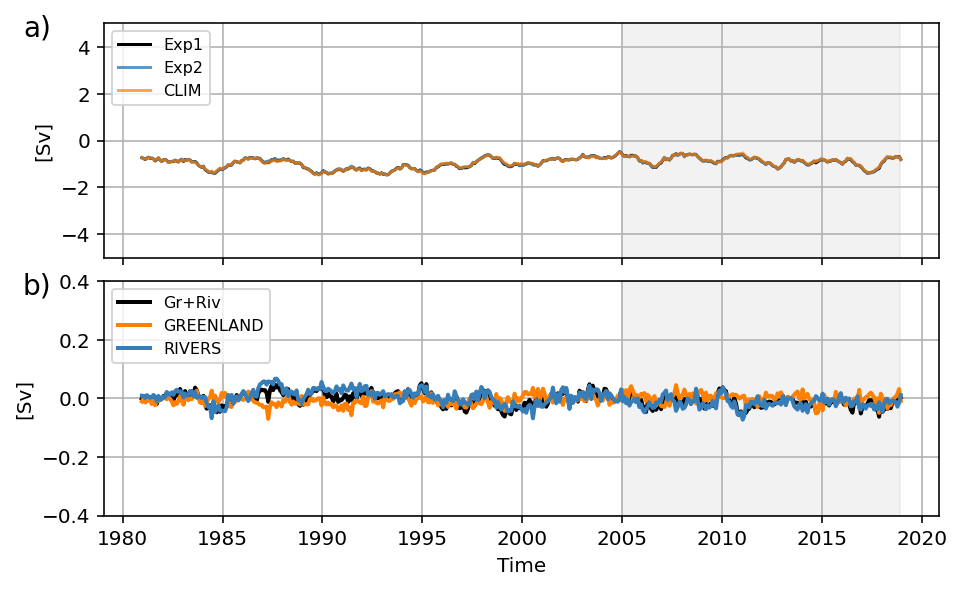

In [6]:
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/" # plot directory
namo = 'SI_ts_PSI_AO.jpg'

print(namo)
cm = 1/2.54  # centimeters in inches
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(19*cm, 11.5*cm), facecolor='none', dpi=72*2, sharex=True)

############-------------  Mean 

lim1 = -5
lim2 = 5

(GAI_psi_wtmeanrollmean/1e6).plot(ax=ax0, color="k")
(AI_psi_wtmeanrollmean/1e6).plot(ax=ax0, color=CB_colors["blue"], alpha = 0.8) 
(S_psi_wtmeanrollmean/1e6).plot(ax=ax0, color=CB_colors["orange"],alpha = 0.7) 

ax0.axvspan('2005', '2018-12', color="grey", alpha=0.1)

ax0.set_ylim(lim1,lim2)
# ax0.set_title('')
ax0.grid()
ax0.legend(["Exp1","Exp2", "CLIM"], loc ='upper left',fontsize=8) 
ax0.set_ylabel('[Sv]')
ax0.set_xlabel('')

# ax0.set_title('Mean barotropic stream function in the BGR box')


# ############------------- partie PSI
tt = GAI_S_psi_wtmeanrollmean.time_counter

lim1 = -0.4
lim2 = 0.4

ax1.plot(tt, (GAI_S_psi_wtmeanrollmean  /1e6), color='k',linewidth=2)
ax1.plot(tt, (GAI_AI_psi_wtmeanrollmean /1e6), linewidth=2,color=CB_colors['orange'])
ax1.plot(tt, (AI_S_psi_wtmeanrollmean   /1e6), linewidth=2,color=CB_colors['blue'])

# ax1.plot(time4plot,trGAI_S4plot  ,color='k'               ,linestyle='dashed')
# ax1.plot(time4plot,trGAI_AI4plot,color=CB_colors['orange'],linestyle='dashed')
# ax1.plot(time4plot,trAI_S4plot  ,color=CB_colors['blue'],linestyle='dashed')

ax1.axvspan('2005', '2018-12', color="grey", alpha=0.1)
ax1.set_ylim(lim1,lim2)
ax1.grid()
ax1.legend(['Gr+Riv',"GREENLAND","RIVERS"], loc="upper left", fontsize=8)
ax1.set_ylabel('[Sv]')
# ax1.set_title('Barotropic stream function')

ax1.set_xlabel('Time'); 

ax0.text(-0.08, 0.98, 'a)', fontsize=14, horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
ax1.text(-0.08, 0.98, 'b)', fontsize=14, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
plt.subplots_adjust(hspace=0.1)

plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), pad_inches=0.1, bbox_inches='tight') #,edgecolor='none', bbox_inches='tight'
# plt.close(fig)